<a href="https://colab.research.google.com/github/WesleyHung/comp3359-Emotion-Analysis/blob/master/Copy_of_project_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comp3359 Project
# Emotion Analysis AI machine


Listed some styles of our machine here...
*   Text classification
*   Supervised learning
*   LSTM (Type of RNN)
*   Attention Mechanism (encoding/ decoding)



# Load the data

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
module_dir = '/content/drive/My Drive/'

# Path to data file
#I put my dataset in my google drive, you can do so by copying from the sharing file
data_path = os.path.join(module_dir, 'text_emotion.csv')    
  
#Loading the dataset into pandas DataFrame
data_df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


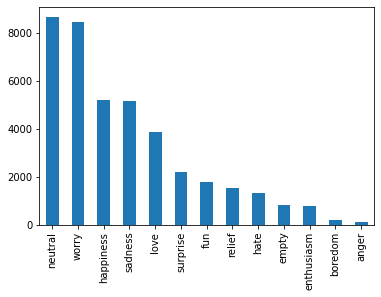

In [51]:
# Plot label histogram
data_df.sentiment.value_counts().plot.bar()

In [52]:
data_df

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


Taking the only useful features

In [53]:
data_df = data_df[['sentiment', 'content']]
data_df

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


# Separate Training/Test Dataset

## Global variable

In [0]:
# Random seed for all random process we will use.
RAND_SEED = 3359
# Size of training dataset (the rest, i.e., 20%,  will be test data)
TRAIN_SIZE = 0.8

## Seperate dataset

In [80]:
all_idx = list(range(len(data_df)))

# Shuffle the list of indices
import random
random.seed(RAND_SEED)
random.shuffle(all_idx)

# Split the random indices into two portion according 
# to the training size defined
p = int(len(data_df) * TRAIN_SIZE)
train_idx = all_idx[:p]
test_idx = all_idx[p:]

# Now, retrieve training/test data records from data_df 
# according to the indices we prepared in train_idx and test_idx
train_df = data_df.iloc[train_idx]
test_df = data_df.iloc[test_idx]

# However, since the original indices from data_df will be attached to 
# the retrieved records in train_df and test_df,
# we need to reset index so indices in train_df/test_df will start from 0 as usual
train_df = train_df.reset_index()
test_df = test_df.reset_index()

# Drop the automatically created "index" column
train_df = train_df.drop(['index'], axis=1)
test_df = test_df.drop(['index'], axis=1)

test_df.head()

,sentiment,content
0,love,"@nomaez hey man, thanks for twitting for twitt..."
1,enthusiasm,add me on myspace?? www.myspace.com/pwnage_org...
2,sadness,Almost made it to reading comedy outlet. Headl...
3,neutral,@Mira_Brody What is BF ? Is it a glue ?
4,worry,It appears I'm going home tomorrow...and it's ...


# Preprossesing the data

## Label the emotions as target

In [0]:
labels = train_df["sentiment"].values.tolist()
val_labels = test_df["sentiment"].values.tolist()

## Creating list of emotions

In [57]:
label2id = dict()
label2id = {l: i for i, l in enumerate(set(labels))}
print(label2id)
id2label = {v: k for k, v in label2id.items()}
print(id2label)

{'boredom': 0, 'anger': 1, 'sadness': 2, 'neutral': 3, 'fun': 4, 'surprise': 5, 'worry': 6, 'empty': 7, 'enthusiasm': 8, 'love': 9, 'relief': 10, 'hate': 11, 'happiness': 12}
{0: 'boredom', 1: 'anger', 2: 'sadness', 3: 'neutral', 4: 'fun', 5: 'surprise', 6: 'worry', 7: 'empty', 8: 'enthusiasm', 9: 'love', 10: 'relief', 11: 'hate', 12: 'happiness'}


the following codes are refernce from kaggle, it can be ignored.

In [58]:
"""
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()


max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2word = {v: k for k, v in word2id.items()}
id2word
"""

'\n# Initialize word2id and label2id dictionaries that will be used to encode words and labels\nword2id = dict()\n\n\nmax_words = 0 # maximum number of words in a sentence\n\n# Construction of word2id dict\nfor sentence in input_sentences:\n    for word in sentence:\n        # Add words to word2id dict if not exist\n        if word not in word2id:\n            word2id[word] = len(word2id)\n    # If length of the sentence is greater than max_words, update max_words\n    if len(sentence) > max_words:\n        max_words = len(sentence)\n    \n# Construction of label2id and id2label dicts\nlabel2id = {l: i for i, l in enumerate(set(labels))}\nid2label = {v: k for k, v in label2id.items()}\nid2word = {v: k for k, v in word2id.items()}\nid2word\n'

# Applying byte pair encoding to word segmentation

In [59]:
# we use the folowwing module for word segmentation
!pip install subword-nmt
"""
bpe_dir = "/content/drive/My Drive/Colab Notebooks/wmt16_en_de.tar/"
codes = 'bpe.32000'
codes_file_path = os.path.join(bpe_dir, codes)
"""

In [0]:
#extract the 'content' data as we only need the content to be segmented
train_df_content = train_df['content']
test_df_content = test_df['content']

f_train = open("train_content.txt", "a")
f_train.write('bpe_content\n')  # make a name for the data

f_test = open("test_content.txt", "a")
f_test.write('bpe_content\n')   # make a name for the data

for content in train_df_content:
  f_train.write(content + '\n')

for content in test_df_content:
  f_test.write(content + '\n')

f_train.close()
f_test.close()

In [0]:
num_operations=10000

codes_file = '/content/bpe.32000'
train_df_content = '/content/train_content.txt'
test_df_content = '/content/test_content.txt'

bpe_train_df_content = '/content/bpe_train_df_content.txt'
bpe_test_df_content = '/content/bpe_test_df_content.txt'

In [0]:
#start BPE word segmentation
!subword-nmt apply-bpe -c {codes_file} < {train_df_content} > {bpe_train_df_content}
!subword-nmt apply-bpe -c {codes_file} < {test_df_content} > {bpe_test_df_content}

In [0]:
# convert .txt format back to .csv format
bpe_train_content_df = pd.read_fwf('bpe_train_df_content.txt')
#nmu_train_content_df.to_csv('nmu_train_df_content.csv')

bpe_test_content_df = pd.read_fwf('bpe_test_df_content.txt')
#nmu_test_content_df.to_csv('nmu_test_df_content.csv')


#merge them back to dataframe format
train_df['bpe_content'] = bpe_train_content_df
test_df['bpe_content'] = bpe_test_content_df

In [97]:
train_df

,sentiment,content,bpe_content
0,enthusiasm,@LeslieCraig haha maybe someday I will be your...,@@@ Les@@ lie@@ Cra@@ ig ha@@ ha maybe som@@ e...
1,happiness,Skipping school like all the cool kids do,Ski@@ pping school like all the cool kids do
2,worry,missing cat makes me sad,missing cat makes me sad
3,neutral,"@lisamh77 Concord &amp; Irvine, CA only. That'...",@@@ li@@ sam@@ h@@ 77 Con@@ cor@@ d &amp; Ir@@...
4,love,"@steph1985 Bye Btw, you like Simple Plan, Hoo...","@@@ st@@ eph@@ 1985 B@@ ye B@@ tw@@ , you like..."
...,...,...,...
31995,love,@manoyjoe: thanks. happy mother's day to your ...,@@@ man@@ o@@ y@@ jo@@ e@@ : than@@ ks@@ . hap...
31996,empty,I jus dropped my dog and im tall.,I j@@ us dropped my dog and im t@@ all@@ .
31997,love,@gio511 We should have a twitter reunion it wo...,@@@ gi@@ o@@ 5@@ 11 We should have a twi@@ tte...
31998,worry,@positron76 You have to come to Chile... with ...,@@@ posi@@ tron@@ 76 You have to come to Chi@@...


## Encoding labels with corresponing integer values

In [0]:
#reference to the online material
import keras

# Encode input words and labels
"""X = [[word2id[word] for word in sentence] for sentence in input_sentences]"""
Y = [label2id[label] for label in labels]
val_Y = [label2id[label] for label in val_labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
"""X = pad_sequences(X, max_words)"""

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')
val_Y = keras.utils.to_categorical(val_Y, num_classes=len(label2id), dtype='float32')
# Print shapes
"""print("Shape of X: {}".format(X.shape))"""
print("Shape of Y: {}".format(Y.shape))
print("Shape of val_Y: {}".format(val_Y.shape))

Shape of Y: (32000, 13)
Shape of val_Y: (8000, 13)


## Encoding the training dataset and validation dataset

In [0]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    
    if max_length > MAX_SEQUENCE_LENGTH:
      max_length = MAX_SEQUENCE_LENGTH
    
    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index, max_length

In [0]:
train, val, word_index, max_words = sequence_vectorize(train_df['content'], test_df['content'])

# Build LSTM model with attention

In [0]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(train) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 100)      3200100     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 100)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 35, 200)      160800      dropout_1[0][0]                  
____________________________________________________________________________________________

# Train the model

In [0]:
# Train model 10 iterations
model.fit(train, Y, epochs=10, batch_size=64, validation_split=0.1, shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28800 samples, validate on 3200 samples
Epoch 1/10
28800/28800 [==============================] - 62s 2ms/step - loss: 2.0874 - accuracy: 0.2742 - val_loss: 1.9252 - val_accuracy: 0.3291
Epoch 2/10
28800/28800 [==============================] - 61s 2ms/step - loss: 1.8330 - accuracy: 0.3820 - val_loss: 1.8866 - val_accuracy: 0.3525
Epoch 3/10
28800/28800 [==============================] - 61s 2ms/step - loss: 1.6528 - accuracy: 0.4477 - val_loss: 1.9635 - val_accuracy: 0.3413
Epoch 4/10
28800/28800 [==============================] - 60s 2ms/step - loss: 1.4543 - accuracy: 0.5247 - val_loss: 2.0802 - val_accuracy: 0.3187
Epoch 5/10
28800/28800 [==============================] - 61s 2ms/step - loss: 1.2563 - accuracy: 0.5944 - val_loss: 2.2940 - val_accuracy: 0.3075
Epoch 6/10
28800/28800 [==============================] - 61s 2ms/step - loss: 1.0782 - accuracy: 0.6525 - val_loss: 2.6620 - val_accuracy: 0.2962
Epoch 7/10
28800/28800 [==============================] - 60s 2ms/ste

In [0]:
import torch
from torchvision import datasets, models, transforms

mdoel_save_name = "lstm_attention_v1_trained.h5" 
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)


If you want to use the existing model, I've already store it in our shared file. 

In [0]:
"""
!pip install gdown==3.6.0

my_file_id = "1M1VxKSiCgecAkogInyEwc4Phx3b9PzbF"
!gdown https://drive.google.com/uc?id={my_file_id}
"""

  Created wheel for gdown: filename=gdown-3.6.0-cp36-none-any.whl size=5238 sha256=862dcbb3adcfd348dbc5f8ed3eb9be2f216a3a1071059fcf994634c6f65685c8
  Stored in directory: /root/.cache/pip/wheels/97/90/fa/25654eb65da3e6da7752db71a164e0eb8f7a6fb4335eeb46ab
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Downloading...
From: https://drive.google.com/uc?id=1M1VxKSiCgecAkogInyEwc4Phx3b9PzbF
To: /content/lstm_attention_v1_trained.h5
40.6MB [00:00, 74.1MB/s]


In [0]:
"""
import keras
model_from_drive = keras.models.load_model('lstm_attention_v1_trained.h5')
"""

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Testing and predicting

## Test

In [0]:

# Create a new model instance
#If you using the loaded model, uncomment this line:
#model = model_from_drive


# Re-evaluate the model
loss, acc = model.evaluate(val, val_Y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


Restored model, accuracy: 10.37%


## Predict

In [0]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

"""
# If you just use the downloaded model wothout trained yourself, please use here:
model_with_attentions = keras.Model(inputs=model_from_drive.input,
                                    outputs=[model_from_drive.output, 
                                             model_from_drive.get_layer('attention_vec').output])
"""

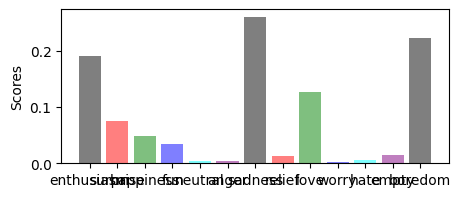

In [0]:
import random
import math

# Select random samples to illustrate
sample_text = "fuck"
sample_text = sample_text.lower()
#sample_text = random.choice(val)


# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word_index[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

#encoded_samples = sample_text
#print(encoded_samples.shape)
# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()


In case the above chart is hard to see, here is the list of proboabilities showing the likeliness of emotions.

In [0]:
import operator

# create a list of emotion in decending order of their probability 
emotion_list=[]

for  _, emotion in enumerate(label_probs):
    temp = [emotion, label_probs[emotion]]
    emotion_list.append(temp)

sorted(emotion_list, key=operator.itemgetter(1), reverse= True)

[['sadness', 0.26072118],
 ['boredom', 0.22221008],
 ['enthusiasm', 0.19029243],
 ['love', 0.12629803],
 ['surprise', 0.0747112],
 ['happiness', 0.04855724],
 ['fun', 0.03365236],
 ['empty', 0.015033543],
 ['relief', 0.013303055],
 ['hate', 0.0050725946],
 ['neutral', 0.0038676239],
 ['anger', 0.0033641763],
 ['worry', 0.002916514]]

# Serveral gusses of improving the model 

*   half the data with labels of many dataset
*   cut out the label with too few dataset
*   using sub-wording tokenization
*   (List item)

